# ChatBot Let's Get Lost!

Notebook ini berisi dalam pembuatan model chatbot AI menggunakan JSON format file lalu mengunakan library TensorFlow dengan Keras dalam Python.

## Import Libraries

In [1]:
# Import Library
import json
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout


# Words Pre
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TheSevenS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Data

In [2]:
# load json file

data_file = open('intents.json').read()
intents_json = json.loads(data_file)

In [3]:
# Create list from json
patterns = [] # Input
tag = [] # Classes/intent

for i in range(len(intents_json['intents'])):
    for user_patterns in intents_json['intents'][i]['patterns']:
        patterns.append(user_patterns)
        tag.append(intents_json['intents'][i]['tag'])


In [4]:
# Create dataframe from json
df = pd.DataFrame({
    'patterns': patterns,
    'tag' : tag,
})
df.head()

,patterns,tag
0,Hai,greet
1,Hi,greet
2,Halo,greet
3,Apa Kabar,greet
4,Selamat Pagi,greet


## Preprocessing

**Splitting Data**

In [5]:
X = df['patterns']
y = df['tag']

In [6]:
# Splitting Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50, stratify = y)

print('Ukuran dimensi Data Trainval-set: ', X_train.shape)
print('Ukuran dimensi Data Test-set: ', X_test.shape)

Ukuran dimensi Data Trainval-set:  (163,)
Ukuran dimensi Data Test-set:  (70,)


In [7]:
y_train.value_counts()

greet                 12
creator                8
pilihan                8
bye                    8
thanks                 8
pembayaran             8
nanya_apps             8
sop_covid              8
reschedule_bantuan     7
complain_marah         7
mengubah_pilihan       6
nanya_gobot            6
nama                   5
refund                 5
tanya wisata alam      5
pilihan_2              5
weblink                5
dokumen                5
reschedule_info        4
pembayaran_error       4
canda                  4
vaksin_info            4
complain               4
keamanan_data          4
canda_3                3
salah_input            3
random_talk3           3
random_talk            3
canda_2                3
Name: tag, dtype: int64

In [8]:
y_test.value_counts()

greet                 5
pilihan               4
pembayaran            4
dokumen               3
creator               3
sop_covid             3
refund                3
complain_marah        3
bye                   3
thanks                3
nanya_apps            3
reschedule_bantuan    3
nanya_gobot           2
nama                  2
tanya wisata alam     2
random_talk           2
complain              2
canda                 2
keamanan_data         2
vaksin_info           2
pembayaran_error      2
reschedule_info       2
pilihan_2             2
mengubah_pilihan      2
weblink               2
random_talk3          1
canda_3               1
salah_input           1
canda_2               1
Name: tag, dtype: int64

**Clean Text**

In [9]:
# Clean text
def clean_text(text):
    """
    Fungsi yang digunakan untuk melakukan praproses
    """
    # konversi ke lowercase
    text = text.lower()
    # menghapus tanda baca
    tandabaca = tuple(string.punctuation)
    text = ''.join(ch for ch in text if ch not in tandabaca)
    return text

In [10]:
# Konfirmasi function diatas
kalimat = 'Halo boleh bantuannya?'
clean_text(kalimat)

'halo boleh bantuannya'

In [11]:
X_train = X_train.apply(clean_text)
X_train.head()

70                    link apps nya apa
190                      cara ubah nama
182    aku mau mengubah pilihan liburan
212                  data kami diapakan
17                                dadah
Name: patterns, dtype: object

**Tokenizing**

Setelah melakukan cleaning data, selanjutnya saya akan menggunakan nltk.word_tokenize untuk menggabungkan list kalimat yang ada untuk menjadi satu kalimat berdasarkan tags.

Tokenizing merupakan salah satu jenis preprocessing yang dilakukan sebelum membuat machine learning model. Tokenizing merupakan hal dasar pada data text.

In [12]:
# Create corpus
words = set([
    word for word in X_train for word in word_tokenize(word)
    ]
)

In [13]:
corpus_size = len(words)

In [14]:
# Pengunaan tokenize pada text
df['length'] = X_train.apply(word_tokenize).apply(len)
sequence_length = int(round(df['length'].max(),0))
print(corpus_size,sequence_length)

174 8


**Encoding**

In [15]:
# Label Encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train)

In [16]:
y_test = encoder.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test)

In [17]:
print(encoder.classes_)

['bye' 'canda' 'canda_2' 'canda_3' 'complain' 'complain_marah' 'creator'
 'dokumen' 'greet' 'keamanan_data' 'mengubah_pilihan' 'nama' 'nanya_apps'
 'nanya_gobot' 'pembayaran' 'pembayaran_error' 'pilihan' 'pilihan_2'
 'random_talk' 'random_talk3' 'refund' 'reschedule_bantuan'
 'reschedule_info' 'salah_input' 'sop_covid' 'tanya wisata alam' 'thanks'
 'vaksin_info' 'weblink']


In [18]:
print(len(encoder.classes_))

29


**Vectorization**

Vektorisasi merupakan metode *bag of words* merupakan metode pengumpulan vocab pada corpus, metode yang saya gunakan pada hal ini adalah text vectorization yang terdapat pada TensorFlow kit.

In [19]:
vect = tf.keras.layers.TextVectorization(
    max_tokens=corpus_size,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=sequence_length
)
vect.adapt(X_train)   

In [20]:
check = 'halo boleh bantuannya?'
vect(clean_text(check))

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([143,   1,   1,   0,   0,   0,   0,   0], dtype=int64)>

**Embedding**

In [21]:
# Define function Embedding
embedding = tf.keras.layers.Embedding(
    input_dim=corpus_size,
    output_dim=16,
    input_length=sequence_length,
    embeddings_initializer='uniform'
)

In [22]:
# Show vector value from text check
embedding(vect(clean_text(check)))

<tf.Tensor: shape=(8, 16), dtype=float32, numpy=
array([[-0.04450644, -0.017117  , -0.0050404 , -0.01686976,  0.04061216,
         0.00769783,  0.01735086, -0.02149274,  0.03278548,  0.04695627,
        -0.03971088,  0.03847608, -0.02638775,  0.03015796,  0.00048444,
        -0.03847359],
       [-0.01957269,  0.04665721,  0.04475385,  0.02230271, -0.03599774,
        -0.03217723,  0.00822517, -0.00350789, -0.02783493, -0.01313834,
        -0.00832633,  0.01411993,  0.00276369, -0.01479509, -0.01795298,
        -0.02396485],
       [-0.01957269,  0.04665721,  0.04475385,  0.02230271, -0.03599774,
        -0.03217723,  0.00822517, -0.00350789, -0.02783493, -0.01313834,
        -0.00832633,  0.01411993,  0.00276369, -0.01479509, -0.01795298,
        -0.02396485],
       [ 0.00717758, -0.04717542, -0.02071076, -0.02321426,  0.00192751,
         0.00089649, -0.04370483, -0.02600048, -0.02808129, -0.01835576,
        -0.00445247, -0.00552479, -0.00441501,  0.04887674, -0.04902666,
        -

**Pipeline Tensorflow**

In [23]:
y_train.shape

(163, 29)

In [46]:
# data train
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(163).batch(8)  # shuffle sebanyak jumlah baris data train

In [47]:
# data test
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8)

In [48]:
X_train


70                    link apps nya apa
190                      cara ubah nama
182    aku mau mengubah pilihan liburan
212                  data kami diapakan
17                                dadah
                     ...               
224                          apps jelek
175              butuh dokumen apa saja
206                dimana tempat vaksin
173             bantuin reschedule dong
62                              appsnya
Name: patterns, Length: 163, dtype: object

## Model Training

From this chapter we will try train our data with LSTM (Long Short Term Memory) from tensorflow to make prediction for answer of the ChatBot.

In [49]:
# Functional API Model

input = tf.keras.layers.Input(shape=(1,), dtype='string')
hidden_1 = vect(input)
hidden_2 = embedding (hidden_1)
hidden_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(hidden_2)
output = tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')(hidden_3)
model = tf.keras.Model(inputs=input, outputs=output)



#Compile Model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')


In [28]:
# Functional API Model

# input = tf.keras.layers.Input(shape=(1,), dtype='string')
# hidden_1 = vect(input)
# hidden_2 = embedding (hidden_1)
# hidden_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True))(hidden_2) 
# hidden_4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(hidden_3)
# output = tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')(hidden_4)
# model = tf.keras.Model(inputs=input, outputs=output)


# #Compile Model
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

In [50]:
# Show summary of model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 8)                0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 8, 16)             2784      
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 29)                957       
                                                                 
Total params: 7,965
Trainable params: 7,965
Non-trainable p

In [51]:
hist = model.fit(train_dataset, validation_data = test_dataset,  epochs=100, verbose=0)
pd.DataFrame(hist.history).tail()

,loss,accuracy,val_loss,val_accuracy
95,0.020339,1.0,2.663739,0.500000
96,0.019876,1.0,2.661391,0.485714
97,0.019440,1.0,2.676039,0.485714
98,0.019008,1.0,2.667031,0.485714
99,0.018603,1.0,2.677122,0.485714


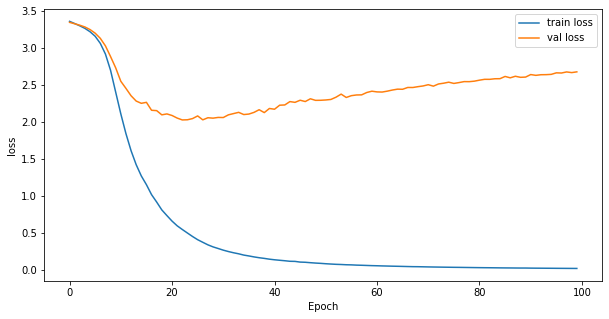

In [52]:
# visualisasi hasil training basic model rnn
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(hist.epoch[-1]+1),hist.history['loss'],label='train loss')
ax.plot(range(hist.epoch[-1]+1),hist.history['val_loss'],label='val loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
plt.legend()
plt.show()

**Saving Model**

In [53]:
# Save Encoder

with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [54]:
pickle.dump({'config': vect.get_config(),
             'weights': vect.get_weights()}
            , open("vect.pkl", "wb"))

In [55]:
model.save('model.tf', save_traces=True)

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


## Inference

In [35]:
def bot_response(text):
    """Take text as function input then predict using model. Return response based on highest probability using numpy argmax    
    """
    text = clean_text(text)
    pred = model.predict([text])
    res = encoder.classes_[pred.argmax()] # Mencari index yang memiliki probabilitas tertinggi
    i = 0
    try:
        if vect(text).numpy().max() > 1: # If the input is known word(s)
            while i < len(intents_json['intents']):
                if res == intents_json['intents'][i]['tag']:
                    responses = intents_json['intents'][i]['responses']
                    break
                else:
                    i+=1
        else: # If only unknown word(s)
            responses = ['Maaf kawan, aku tidak mengerti perkataan mu ...']
    except: # If empty string or any error occured
        responses = ['GoBot tidak mengerti :( ...']

    # For debugging only
    dict_temp = []
    for i in range(len(pred[0])):
        temp = {encoder.classes_[i]: pred[0][i]}
        dict_temp.append(temp)
    print(dict_temp)
    print(encoder.classes_[pred.argmax()])

    return(np.random.choice(responses))

In [36]:
tes1 = 'hai'
clean_text(tes1)

'hai'

In [37]:
model.predict([clean_text(tes1)])

1/1 [==============================] - 1s 1s/step


array([[1.0282357e-02, 1.4568812e-03, 1.7543568e-04, 3.1464744e-05,
        5.1664589e-05, 1.1466248e-03, 5.0905679e-04, 1.0977087e-03,
        5.9307963e-03, 3.7058126e-05, 5.4996431e-06, 5.3460355e-04,
        5.9388135e-02, 4.1966859e-02, 1.1585504e-02, 5.4320338e-04,
        1.6461030e-03, 1.8821680e-04, 5.4762489e-04, 1.3510495e-07,
        5.3083419e-05, 9.3254792e-05, 1.5876787e-05, 1.8511171e-06,
        1.4651136e-02, 8.8650231e-06, 8.4790671e-01, 1.2867104e-05,
        1.3148964e-04]], dtype=float32)

In [38]:
model.predict([clean_text(tes1)]).argmax()

1/1 [==============================] - 0s 28ms/step


26

In [39]:
encoder.classes_[model.predict([clean_text(tes1)]).argmax()]


1/1 [==============================] - 0s 28ms/step


'thanks'

In [40]:
intents_json['intents'][4]['responses']

['GoBot merupakan online Chatbot, yang dapat membantu kawan untuk mecarikan rekomendasi tempat kawan liburan.',
 'Salam kenal aku GoBot',
 'Panggil aku GoBot kawan :)',
 'Aku GoBot!',
 'Perkenalkan aku GoBot']

In [41]:
bot_response('')

1/1 [==============================] - 0s 27ms/step
[{'bye': 0.016788583}, {'canda': 0.0021324165}, {'canda_2': 0.00021285449}, {'canda_3': 2.7538941e-05}, {'complain': 3.0049758e-05}, {'complain_marah': 0.0006764973}, {'creator': 0.0004074495}, {'dokumen': 0.0014819383}, {'greet': 0.008652421}, {'keamanan_data': 2.9225503e-05}, {'mengubah_pilihan': 6.011419e-06}, {'nama': 0.0008038508}, {'nanya_apps': 0.033891607}, {'nanya_gobot': 0.074306644}, {'pembayaran': 0.018373461}, {'pembayaran_error': 0.00046996633}, {'pilihan': 0.0023890303}, {'pilihan_2': 0.00031272802}, {'random_talk': 0.00050499453}, {'random_talk3': 1.7338355e-07}, {'refund': 8.792205e-05}, {'reschedule_bantuan': 0.00014488088}, {'reschedule_info': 3.110614e-05}, {'salah_input': 1.103946e-06}, {'sop_covid': 0.019728137}, {'tanya wisata alam': 1.656065e-05}, {'thanks': 0.8183686}, {'vaksin_info': 1.0719335e-05}, {'weblink': 0.000113592345}]
thanks


'GoBot tidak mengerti :( ...'

In [42]:
bot_response('Halo!')

1/1 [==============================] - 0s 37ms/step
[{'bye': 0.00018788589}, {'canda': 0.0028878502}, {'canda_2': 2.3080349e-05}, {'canda_3': 9.586507e-06}, {'complain': 3.008553e-06}, {'complain_marah': 8.5835396e-05}, {'creator': 0.00023547075}, {'dokumen': 0.00032587815}, {'greet': 0.97452456}, {'keamanan_data': 1.8340517e-05}, {'mengubah_pilihan': 0.00011339223}, {'nama': 0.00021025894}, {'nanya_apps': 0.0008216914}, {'nanya_gobot': 0.0009202442}, {'pembayaran': 0.0012269367}, {'pembayaran_error': 0.0011567794}, {'pilihan': 0.0028104351}, {'pilihan_2': 2.7121663e-05}, {'random_talk': 9.506641e-05}, {'random_talk3': 2.8849857e-07}, {'refund': 0.00085488235}, {'reschedule_bantuan': 0.00055018725}, {'reschedule_info': 0.00016968008}, {'salah_input': 2.6107335e-07}, {'sop_covid': 0.00581381}, {'tanya wisata alam': 7.133755e-06}, {'thanks': 0.00676768}, {'vaksin_info': 8.315358e-07}, {'weblink': 0.0001518114}]
greet


'Hai Kawan Gobot'

In [43]:
bot_response('bali')

1/1 [==============================] - 0s 29ms/step
[{'bye': 0.00031148977}, {'canda': 0.09533282}, {'canda_2': 0.00047143013}, {'canda_3': 0.0011075889}, {'complain': 2.5697513e-05}, {'complain_marah': 3.4571673e-05}, {'creator': 9.543765e-06}, {'dokumen': 0.023383673}, {'greet': 0.0074723545}, {'keamanan_data': 0.0008417466}, {'mengubah_pilihan': 0.0014767386}, {'nama': 6.621531e-06}, {'nanya_apps': 0.0001164222}, {'nanya_gobot': 0.00024413719}, {'pembayaran': 0.00025506326}, {'pembayaran_error': 0.004522836}, {'pilihan': 0.8459014}, {'pilihan_2': 0.0013721872}, {'random_talk': 1.4475309e-05}, {'random_talk3': 1.3315518e-07}, {'refund': 0.0021569899}, {'reschedule_bantuan': 0.0041491906}, {'reschedule_info': 0.00020264367}, {'salah_input': 4.823164e-06}, {'sop_covid': 0.0030642275}, {'tanya wisata alam': 0.00010173203}, {'thanks': 0.006600521}, {'vaksin_info': 9.409729e-06}, {'weblink': 0.0008095368}]
pilihan


'Mohon maaf kami hanya tersedia untuk liburan di Labuan Bajo saja.'

In [44]:
bot_response('Dadah!')

1/1 [==============================] - 0s 31ms/step
[{'bye': 0.96672744}, {'canda': 0.00024129644}, {'canda_2': 0.0013098845}, {'canda_3': 9.844987e-07}, {'complain': 0.00012588136}, {'complain_marah': 0.0018167015}, {'creator': 0.0030444008}, {'dokumen': 0.0001826118}, {'greet': 0.00027959768}, {'keamanan_data': 3.9179482e-05}, {'mengubah_pilihan': 2.1132125e-06}, {'nama': 0.008001266}, {'nanya_apps': 0.00010901369}, {'nanya_gobot': 0.0020965347}, {'pembayaran': 0.0026574307}, {'pembayaran_error': 1.9966553e-06}, {'pilihan': 3.452605e-05}, {'pilihan_2': 0.0010872519}, {'random_talk': 0.0004163614}, {'random_talk3': 1.3386053e-06}, {'refund': 8.61584e-07}, {'reschedule_bantuan': 3.4418265e-06}, {'reschedule_info': 0.00012260256}, {'salah_input': 5.5998594e-06}, {'sop_covid': 0.0024591752}, {'tanya wisata alam': 6.196432e-05}, {'thanks': 0.008766683}, {'vaksin_info': 0.00020395652}, {'weblink': 0.00020005512}]
bye


'Kalau butuh bantuan, hubungi GoBot lagi ya'

In [45]:
bot_response('Halo!')

1/1 [==============================] - 0s 26ms/step
[{'bye': 0.00018788589}, {'canda': 0.0028878502}, {'canda_2': 2.3080349e-05}, {'canda_3': 9.586507e-06}, {'complain': 3.008553e-06}, {'complain_marah': 8.5835396e-05}, {'creator': 0.00023547075}, {'dokumen': 0.00032587815}, {'greet': 0.97452456}, {'keamanan_data': 1.8340517e-05}, {'mengubah_pilihan': 0.00011339223}, {'nama': 0.00021025894}, {'nanya_apps': 0.0008216914}, {'nanya_gobot': 0.0009202442}, {'pembayaran': 0.0012269367}, {'pembayaran_error': 0.0011567794}, {'pilihan': 0.0028104351}, {'pilihan_2': 2.7121663e-05}, {'random_talk': 9.506641e-05}, {'random_talk3': 2.8849857e-07}, {'refund': 0.00085488235}, {'reschedule_bantuan': 0.00055018725}, {'reschedule_info': 0.00016968008}, {'salah_input': 2.6107335e-07}, {'sop_covid': 0.00581381}, {'tanya wisata alam': 7.133755e-06}, {'thanks': 0.00676768}, {'vaksin_info': 8.315358e-07}, {'weblink': 0.0001518114}]
greet


'Halo!'